In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import keras
keras.__version__

from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.models import load_model
import h5py


from keras.utils import to_categorical

In [6]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [29]:
### loading data
full_data=[]
labels=[]
staggered=[]

for jay in range(1,10):
  part_data=[]
  data_path='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/0.'+str(jay)+'.txt'
  with open(data_path, newline='\n') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for line in csv_reader:
      part_data.append(line)

  for x in part_data:
    x.remove('')
  
  subtotal=[]
  jay=jay/10
  for element in part_data:
    TT=element.pop(0)  # removes T
    if np.float(TT)==0.02:
      config=[float(i) for i in element]
      sum=0
      fila=-1
      for index in range(len(config)):
        if index%30==0:
          fila+=1
          offset=29
        if fila%2==0:
          if index%2==0:
            sum+=config[index]
          else:
            sum-=config[index]
        else:
          if index%2==0:
            sum+=config[index + offset]
          else:
            sum-=config[index + offset]
          offset-=2          
      sum=sum/len(config)
      subtotal.append(abs(sum))
      config.insert(0, jay)
      if jay> 0.5:
        config.insert(1,1)
      else:
        config.insert(1,0)
      full_data.append(config)
  m_st=np.mean(subtotal)
  staggered.append(m_st)

In [30]:
for jay in [42,44,46,48,52,54,56,58]:
  part_data=[]
  data_path='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/0.'+str(jay)+'.txt'
  with open(data_path, newline='\n') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for line in csv_reader:
      part_data.append(line)

  for x in part_data:
    x.remove('')

  
  subtotal=[]
  for element in part_data:
    TT=element.pop(0)  # removes T
    if np.float(TT)==0.02: #we will only use configurations for this temperature value
      conf=[float(i) for i in element]
      sum=0
      fila=-1
      for index in range(len(conf)):
        if index%30==0:
          fila+=1
          offset=29
        if fila%2==0:
          if index%2==0:
            sum+=conf[index]
          else:
            sum-=conf[index]
        else:
          if index%2==0:
            sum+=conf[index + offset]
          else:
            sum-=conf[index + offset]
          offset-=2          
      sum=sum/len(conf)
      subtotal.append(abs(sum))
      conf.insert(0, jay/100)
      if (jay/100)> 0.5:
        conf.insert(1,1)
      else:
        conf.insert(1,0)
      full_data.append(conf)
  m_st=np.mean(subtotal)
  staggered.append(m_st)

In [24]:
aba=np.arange(0.1,1.,0.1)
bab=np.array([0.42,0.44,0.48,0.52,0.54,0.56,0.58,0.46])
ListJ=np.concatenate((aba,bab),axis=0)
ListJ

array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.42, 0.44,
       0.48, 0.52, 0.54, 0.56, 0.58, 0.46])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

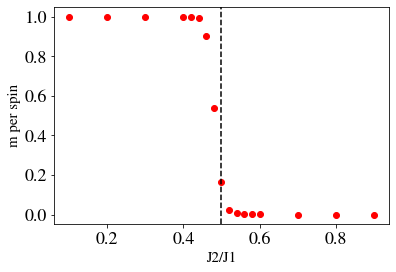

In [ ]:
plt.plot(ListJ, staggered, 'ro')
plt.axvline(x=0.5,color='black',linestyle='--')
plt.xlabel('J2/J1',size = 15)
plt.ylabel('m per spin',size = 15)
plt.savefig('sq_stag.pdf')
files.download('sq_stag.pdf')
plt.show()

In [32]:
random.shuffle(full_data)

jota2=[]
labels=[]
for elemento in full_data:
  JJ=elemento.pop(0)  #removes J2
  jota2.append(JJ) #saves J2 in the J2 list
  etiq=elemento.pop(0)  #removes the label
  labels.append(etiq) #saves label in the label list

#we now have to adapt our data to serve as input of the CNN
length_data=len(full_data)
full_data=np.array(full_data)
full_data=full_data.reshape(length_data,30,30,1)
full_data = full_data.astype(np.float)
full_data=(full_data+1.)/2 #normalization
jota2=np.array(jota2)
jota2 = jota2.astype(np.float)

In [33]:
#we split data to use some of it for training and some for testing
split_val=int(2*length_data/3) #we train with 2/3 of the data
train_data=full_data[:split_val]
train_j2=jota2[:split_val] #(we will define train_labels later)


test_data=full_data[split_val:length_data]
test_j2=jota2[split_val:length_data]
test_labels=labels[split_val:length_data]
test_labels=np.array(test_labels)

test_labels = to_categorical(test_labels)

print(split_val)

4533


In [ ]:
L=30
adan=optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
P_list_30=[]
P1=[]
J_list=[]

for xx in ListJ:
  train_labels=[]
  for yy in range(len(train_data)):
    if train_j2[yy]>= xx:
      train_labels.append(1)
    else:
      train_labels.append(0)
  train_labels = to_categorical(train_labels)
  network = models.Sequential()
  network.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(L, L, 1)))
  network.add(layers.MaxPooling2D((2, 2)))
  network.add(layers.Conv2D(16, (3, 3), activation='relu'))
  network.add(layers.Flatten())
  network.add(layers.Dense(10, activation='relu'))
  network.add(layers.Dense(2, activation='softmax'))
  network.compile(optimizer=adan,
loss='categorical_crossentropy',
metrics=['accuracy'])

  epochs_val=6
  Bsize=200
  history=network.fit(train_data, train_labels,validation_split=0.2,
                      shuffle=True, epochs=epochs_val, batch_size=Bsize)

  history_dict = history.history
  P_list_30.append(history_dict['val_accuracy'][epochs_val - 1])
  perd,accu=network.evaluate(test_data, test_labels)
  P1.append(accu)
  J_list.append(xx)

##
print(P_list_30)

#Confusion graph
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18


plt.plot(J_list, P_list_30, 'ro')
plt.title('Square J1-J2 30x30 lattice - confusion (CNN)',size = 15)
plt.xlabel('J2/J1',size = 15)
plt.ylabel('Accuracy',size = 15)
plt.axvline(x=0.5,color='black',linestyle='--') #there should be a peak for this value

plt.rcParams.update({'figure.autolayout':True})
plt.savefig('confusion_sq.pdf',bbox_inches='tight')
files.download('confusion_sq.pdf')
plt.show()